#IMDB - Sentiment Analysis
Implemented by Muhammad Hanan Asghar

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#Dataset Prepration

In [2]:
!cp "/content/drive/MyDrive/imdb-movie-ratings-sentiment-analysis.zip" "/content"
!unzip *.zip && rm -rf *.zip

Archive:  imdb-movie-ratings-sentiment-analysis.zip
  inflating: movie.csv               


In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("movie.csv")

In [3]:
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [4]:
df.label.unique()

array([0, 1])

In [5]:
df.label.value_counts()

0    20019
1    19981
Name: label, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [4]:
import string

def cleaner(line):
  line = line.lower()
  line = line.strip()
  table = str.maketrans('', '', string.punctuation+string.digits)
  words = line.split()
  stripped = [w.translate(table) for w in words]
  line = " ".join(stripped)
  line = line.replace("  "," ")
  line = line.replace("  "," ")
  return line

In [5]:
sentences = [cleaner(sentence[0]) for sentence in df.iloc[:,:-1].values]
sentences = np.array(sentences)

In [6]:
labels = df.iloc[:, -1].values

In [10]:
df.isnull().sum()

text     0
label    0
dtype: int64

#Plotting Word Cloud

In [11]:
import re
from wordcloud import WordCloud, STOPWORDS

In [12]:
def plot_word_cloud(sentences):
  long_string = ','.join(list(sentences))
  wordcloud = WordCloud(background_color="white", max_words=500, contour_width=3, contour_color='steelblue')
  wordcloud.generate(long_string)
  plt.figure( figsize=(20,10) )
  plt.imshow(wordcloud)
  plt.show()

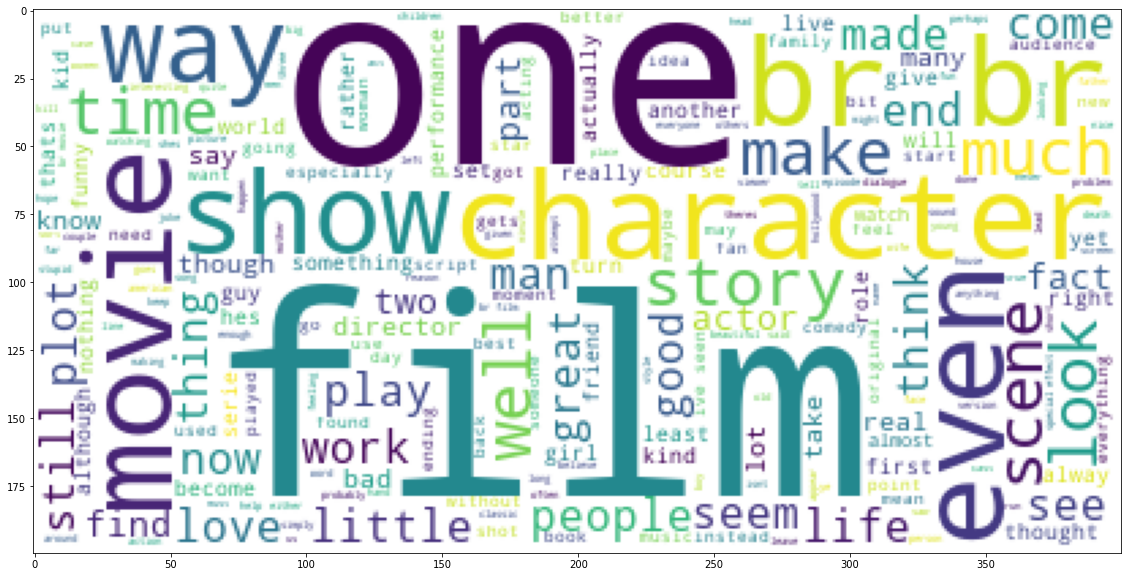

In [13]:
plot_word_cloud(sentences)

#Using Machine Learning

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, random_state=42, test_size=0.3)

In [16]:
vectorizer = CountVectorizer()

X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

In [22]:
# Using Logistic Regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=3000)
lr.fit(X_train_vector, y_train)

LogisticRegression(max_iter=3000)

In [24]:
# Accuracy Score

lr_score = lr.score(X_test_vector, y_test)
print("Results of Logistic Regression Using CountVectorizer")
print(f"Accuracy: {round(lr_score, 2)}%")

Results of Logistic Regression Using CountVectorizer
Accuracy: 0.88%


In [25]:
# Predicting

y_pred = lr.predict(X_test_vector)

In [26]:
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

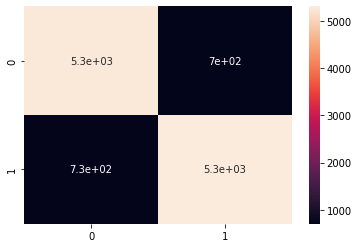

In [30]:
import seaborn as sns

sns.heatmap(cm_lr, annot=True)

#Using Deep Learning

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [8]:
tokenizer = Tokenizer(oov_token="<OOV>")

In [9]:
tokenizer.fit_on_texts(sentences)

In [10]:
sequences = tokenizer.texts_to_sequences(sentences)

In [11]:
max_sequence_len = max([len(sequence) for sequence in sequences])
max_sequence_len

2460

In [12]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, maxlen=max_sequence_len, padding="post", truncating="post")

In [13]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, random_state=42, test_size=0.1)

In [14]:
x_train.shape

(36000, 2460)

In [15]:
x_test.shape

(4000, 2460)

In [16]:
y_train.shape

(36000,)

In [17]:
y_test.shape

(4000,)

In [46]:
import tensorflow as tf

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if logs.get('accuracy') > 0.99:
            print('\n Stopped Training!\n')
            self.model.stop_training = True

In [51]:
vocab_size = len(tokenizer.word_index) + 1
model = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, 64, input_length=max_sequence_len),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(None, 1))),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(1, activation="sigmoid"),
])

Feel free to tune the hyperparameters of the model like changing the optimizer functions, adding extra layers, changing activation functions, and also try increasing the dimensions in the Embedding vector. In this way, you will be able to achieve more refined and fine results.

In [52]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 2460, 64)          10002240  
                                                                 
 bidirectional_13 (Bidirecti  (None, 2460, 128)        66048     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 2460, 128)         0         
                                                                 
 bidirectional_14 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [53]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=adam, 
    metrics=['accuracy']
)

In [54]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="model.h5",  save_weights_only=True, verbose=1)
callback = myCallback()

In [55]:
history = model.fit(
    x_train, y_train, 
    batch_size=64,
    validation_data=(x_test, y_test),
    epochs=10,
    callbacks=[cp_callback, callback]
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


563/563 [==============================] - ETA: 0s - loss: 0.4974 - accuracy: 0.7336
Epoch 1: saving model to model.h5
563/563 [==============================] - 187s 322ms/step - loss: 0.4974 - accuracy: 0.7336 - val_loss: 0.2794 - val_accuracy: 0.8848
Epoch 2/10
563/563 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9260
Epoch 2: saving model to model.h5
563/563 [==============================] - 179s 317ms/step - loss: 0.2047 - accuracy: 0.9260 - val_loss: 0.2548 - val_accuracy: 0.8990
Epoch 3/10
563/563 [==============================] - ETA: 0s - loss: 0.0880 - accuracy: 0.9719
Epoch 3: saving model to model.h5
563/563 [==============================] - 179s 317ms/step - loss: 0.0880 - accuracy: 0.9719 - val_loss: 0.3142 - val_accuracy: 0.8903
Epoch 4/10
563/563 [==============================] - ETA: 0s - loss: 0.0484 - accuracy: 0.9863
Epoch 4: saving model to model.h5
563/563 [==============================] - 178s 317ms/step - loss: 0.0484 - accuracy: 

In [32]:
model.evaluate(x_test, y_test)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


125/125 [==============================] - 17s 124ms/step - loss: 0.3526 - accuracy: 0.8865


[0.35262754559516907, 0.8865000009536743]

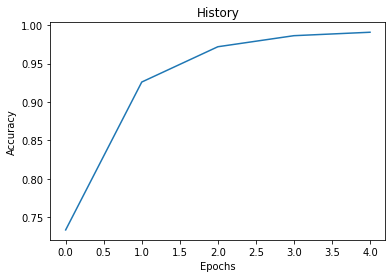

In [56]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['accuracy'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Accuracy")

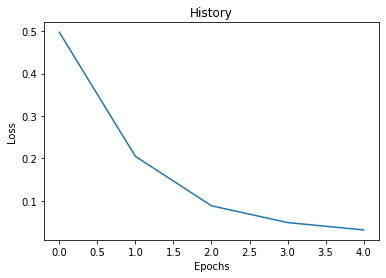

In [58]:
import matplotlib.pyplot as plt
fig = plt.plot(history.history['loss'])
title = plt.title("History")
xlabel = plt.xlabel("Epochs")
ylabel = plt.ylabel("Loss")

In [60]:
sentences[567]

'i saw the german version of the movie in german television and i was really amazed i generally like to see documentaries but i cant remember to have seen one that is better than earth i knew some of the scenes from youtube videos that i found by random browsing i also remember to have seen parts of the film on multimedia stores running on the displayed high definition tvs after seeing the movie its obvious to me why the footage is so popular among youtube users and multimedia retail managers its just so awesome and spectacular that you cant help but stare on the screen no matter if youre generally interested in nature documentaries or notbr br without hesitating a out of for sure there are more thrilling movies but in regard of documentaries earth is definitely one of the best of its genre'

In [62]:
labels[567]

1

In [65]:
pred = model.predict(tf.expand_dims(padded_sequences[567], 0))

In [66]:
pred #Correct 

array([[0.997912]], dtype=float32)

In [67]:
sentences[23465]

'ok im biased i live near shrewsbury in england where this wonderful movie was filmed it still looks the same now i remember them filming here quite vividly and the fake snow on the streets for days on end often when im walking through shrewsbury i see a street or a house and it will remind me of this filmbr br george c scotts scrooge is a more realistic character than many of the other screen versions his physical appearance isnt the typical miser scotts is big and imposing a man who finds those smaller than himself to be inferiorbr br we all know the story and the quotes the book is one of the most cherished works in the english language and i dont believe there are many cynics who would say that people arent capable of change and redemption this film version portrays all of that quite beautifully george c scott may be american but he plays the part of the english miser with wonderful skillbr br i love this movie if you havent seen this version i would strongly urge that you do its u

In [68]:
labels[23465]

1

In [69]:
pred = model.predict(tf.expand_dims(padded_sequences[23465], 0))

In [70]:
pred #Correct

array([[0.99859506]], dtype=float32)

Implemented By Muhammad Hanan Asghar